In [1]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 13187, done.
remote: Counting objects: 100% (1489/1489), done.
remote: Compressing objects: 100% (376/376), done.
remote: Total 13187 (delta 1166), reused 1218 (delta 1098), pack-reused 11698 (from 1)
Receiving objects: 100% (13187/13187), 10.67 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (9970/9970), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793131 sha256=a8fdc51c5d20a5e077f67dd17f7c4e61a86543ab29b878df8da51aee485207bf
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found existi

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
import gym
from torch.nn import functional as F
import math
import neurogym as ngym
import torch.nn.init as init
import scipy.spatial
plt.rcParams['font.family'] = 'DejaVu Sans'

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [28]:
import numpy as np
import numpy.matlib

num_units_rec = 5
e_size = 4
i_size = num_units_rec - e_size

# mask_EI_vec = np.concatenate((np.ones((e_size,1)),-1*np.ones((i_size,1)))).T
# mask_EI_mat_plusdiag = np.matlib.repmat(mask_EI_vec,num_units_rec,1)
# diag_mat = np.zeros((num_units_rec,num_units_rec)) + np.diag(np.ones((num_units_rec)))
# mask_EI_mat = mask_EI_mat_plusdiag - diag_mat

mask_no_diag = np.ones((num_units_rec,num_units_rec)) -  np.diag(np.ones((num_units_rec)))

E_I_unit_list = np.concatenate((np.ones((e_size,1)),-1*np.ones((i_size,1)))).T

E_I_mask = mask_no_diag*E_I_unit_list

print(E_I_mask)

[[ 0.  1.  1.  1. -1.]
 [ 1.  0.  1.  1. -1.]
 [ 1.  1.  0.  1. -1.]
 [ 1.  1.  1.  0. -1.]
 [ 1.  1.  1.  1. -0.]]


In [29]:
import torch

# Define the sparse mask manually
sparse_mask = torch.tensor([
    [1, 1, 1, 0, 0],
    [1, 0, 1, 0, 1],
    [0, 1, 0, 1, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 1, 0]
], dtype=torch.float32)

# Print the mask
print("Sparse Mask:")
print(sparse_mask)

Sparse Mask:
tensor([[1., 1., 1., 0., 0.],
        [1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 1.],
        [1., 1., 0., 0., 1.],
        [1., 1., 1., 1., 0.]])


In [41]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F


class SparseRecLinear(nn.Module):
    """
    Recurrent Linear transformation with sparse mask applied in the same way as EIRNN.

    Args:
        hidden_size: int, number of hidden units.
        sparsity: float, fraction of connections to zero out (0 to 1).
        bias: bool, if True, adds a learnable bias to the output.
    """

    def __init__(self, hidden_size, sparsity=0.5, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.sparsity = sparsity

        # Create a sparse mask dynamically, similar to EIRNN logic
        self.register_buffer("mask", self._generate_sparse_mask())

        # Weight matrix for recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Optional bias
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def _generate_sparse_mask(self):
        """
        Generate a sparse mask with no self-connections, scaled to the hidden size.
        """
        mask_no_diag = np.ones((self.hidden_size, self.hidden_size)) - np.diag(np.ones((self.hidden_size)))

        # Introduce sparsity by randomly setting a fraction of connections to zero
        sparsity_mask = np.random.rand(self.hidden_size, self.hidden_size) > self.sparsity

        # Combine sparsity with no self-connections
        mask = mask_no_diag * sparsity_mask
        return torch.tensor(mask, dtype=torch.float32)

    def reset_parameters(self):
        # Initialize weights and biases
        nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / np.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        """
        Apply the sparse mask to the weights to get the effective weight matrix.
        """
        return self.weight * self.mask

    def forward(self, input):
        """
        Perform the linear transformation with the sparse mask applied to the weights.
        """
        return F.linear(input, self.effective_weight(), self.bias)


class SparseRNN(nn.Module):
    """
    Recurrent Neural Network with sparse recurrent connections.

    Args:
        input_size: Number of input neurons.
        hidden_size: Number of hidden neurons.
        sparsity: Fraction of recurrent connections to zero out (0 to 1).
        dt: Discretization time step (ms).
        tau: Time constant for leaky integration.
        sigma_rec: Noise level for recurrent dynamics.
    """

    def __init__(self, input_size, hidden_size, sparsity=0.5, dt=None, tau=100, sigma_rec=0):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = tau
        self.alpha = dt / tau if dt is not None else 1.0  # Leaky integration factor
        self.sigma_rec = sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = SparseRecLinear(hidden_size, sparsity=sparsity)

    def init_hidden(self, input):
        """
        Initialize the hidden state to zeros.
        """
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """
        Perform a single recurrence step.
        """
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        # Update the state with leaky integration
        state = state * (1 - self.alpha) + total_input * self.alpha

        # Add noise to the state (if specified)
        state += self.sigma_rec * torch.randn_like(state)

        # Apply activation
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """
        Propagate input through the RNN.

        Args:
            input: Tensor of shape (seq_len, batch_size, input_size).
            hidden: Initial hidden state.

        Returns:
            output: Tensor of shape (seq_len, batch_size, hidden_size).
            hidden: Final hidden state.
        """
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])  # Append only the output component
        output = torch.stack(output, dim=0)
        return output, hidden


class SparseNet(nn.Module):
    """
    Complete network with sparse RNN and output layer.

    Args:
        input_size: Number of input features.
        hidden_size: Number of hidden units.
        output_size: Number of output units.
    """

    def __init__(self, input_size, hidden_size, output_size, sparsity=0.5, dt=1, tau=100, sigma_rec=0.0):
        super().__init__()
        self.input_size = input_size
        self.rnn = SparseRNN(input_size, hidden_size, sparsity=sparsity, dt=dt, tau=tau, sigma_rec=sigma_rec)
        self.fc = nn.Linear(hidden_size, output_size)
        self.output_size = output_size

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        out = self.fc(rnn_activity)
        return out, rnn_activity


EIRNN

In [30]:
class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal

        mask_no_diag = np.ones((self.hidden_size,self.hidden_size)) -  np.diag(np.ones((self.hidden_size)))

        E_I_unit_list = np.concatenate((np.ones((self.e_size,1)),-1*np.ones((self.i_size,1)))).T

        mask = mask_no_diag*E_I_unit_list

        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)



class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden

class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory
        self.input_size = input_size
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)
        self.output_size = output_size

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

In [ ]:
LEAKY RNN

In [3]:
class LeakyRNN2(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        state, output = hidden
        h_new = torch.relu(self.input2h(input) + self.h2h(output))
        state = state * (1 - self.alpha) + h_new * self.alpha
        output = torch.relu(state)  # Use ReLU activation for output
        return state, output


    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden


class RNNNet2(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.rnn = LeakyRNN2(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.output_size = output_size

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Distance regularization

In [4]:
class Reg_WD(torch.nn.Module):

    """A regulariser for spatially embedded RNNs.
  Applies L1 regularisation to recurrent kernel of
  RNN which is weighted by the distance of units
  in predefined 3D space.
  Calculation:
      reg_WD * sum[distance_matrix o recurrent_kernel]
  Attributes:
      reg_WD: Float; Weighting of Reg_WD regularisation term.
      network_structure: Defines a 3D grid specifying the
      dimensions of a 3D space where neurons are placed.
      The tuple specifies the range of coordinates along
      each of the three axes in this 3D space.
  """

    def __init__(self, reg_WD=0.01, neuron_num=100, network_structure=(5,5,4), coordinates_list=None, distance_power=1, distance_metric='euclidean'):
        super(Reg_WD, self).__init__()

        self.distance_power = distance_power
        self.reg_WD = torch.tensor([reg_WD], dtype=torch.float32)

        # Set up tensor with distance matrix
        nx = np.arange(network_structure[0])
        ny = np.arange(network_structure[1])
        nz = np.arange(network_structure[2])

        # Set up coordinate grid
        x, y, z = np.meshgrid(nx, ny, nz)
        self.coordinates = [x.ravel(), y.ravel(), z.ravel()]

        # Override coordinate grid if provided in init
        if coordinates_list is not None:
            self.coordinates = coordinates_list

        # Check neuron number / number of coordinates
        if (len(self.coordinates[0]) == neuron_num) and (len(self.coordinates[1]) == neuron_num) and (len(self.coordinates[2]) == neuron_num):
            pass
        else:
            raise ValueError('Network / coordinate structure does not match the number of neurons.')

        # Calculate the euclidean distance matrix
        euclidean_vector = scipy.spatial.distance.pdist(np.transpose(self.coordinates), metric=distance_metric)
        euclidean = scipy.spatial.distance.squareform(euclidean_vector ** self.distance_power)
        self.distance_matrix = torch.tensor(euclidean, dtype=torch.float32)

    def forward(self, x):
        abs_weight_matrix = torch.abs(x)
        WD_loss = self.reg_WD * torch.sum(abs_weight_matrix * self.distance_matrix)
        return WD_loss

    def _check_penalty_number(self, x):
        if not isinstance(x, (float, int)):
            raise ValueError(('Value: {} is not a valid regularization penalty number, '
                              'expected an int or float value').format(x))

    def visualise_distance_matrix(self):
        plt.imshow(self.distance_matrix.numpy())
        plt.colorbar()
        plt.show()

    def visualise_neuron_structure(self):
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(self.coordinates[0], self.coordinates[1], self.coordinates[2], c='b', marker='.')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.show()

    def get_config(self):
        return {'reg_WD': float(self.reg_WD)}


NeuroGym

In [5]:
%%capture
# @title import the task from the neurogym library

import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'PerceptualDecisionMaking-v0'
#task = 'GoNogo-v0'
#task = 'Bandit-v0'
#task = 'ReadySetGo-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=1,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

Training without reg

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SparseNet(
  (rnn): SparseRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): SparseRecLinear()
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
Step 200, Loss 0.5360
Step 400, Loss 0.3795
Step 600, Loss 0.2875
Step 800, Loss 0.2165
Step 1000, Loss 0.1718
Step 1200, Loss 0.1502
Step 1400, Loss 0.1354
Step 1600, Loss 0.1204
Step 1800, Loss 0.1089
Step 2000, Loss 0.1078


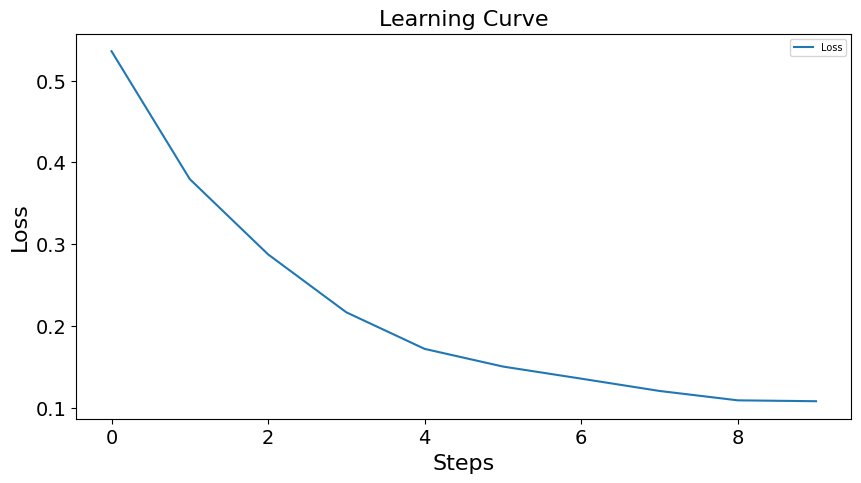

In [43]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = SparseNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Learning Curve",fontsize=16)
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.show()

Train with REG

RNNNet2(
  (rnn): LeakyRNN2(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)
Step 200, Loss 35.2193
Step 400, Loss 0.6139
Step 600, Loss 0.5478
Step 800, Loss 0.5012
Step 1000, Loss 0.4743
Step 1200, Loss 0.4611
Step 1400, Loss 0.4392
Step 1600, Loss 0.4209
Step 1800, Loss 0.4026
Step 2000, Loss 0.3937


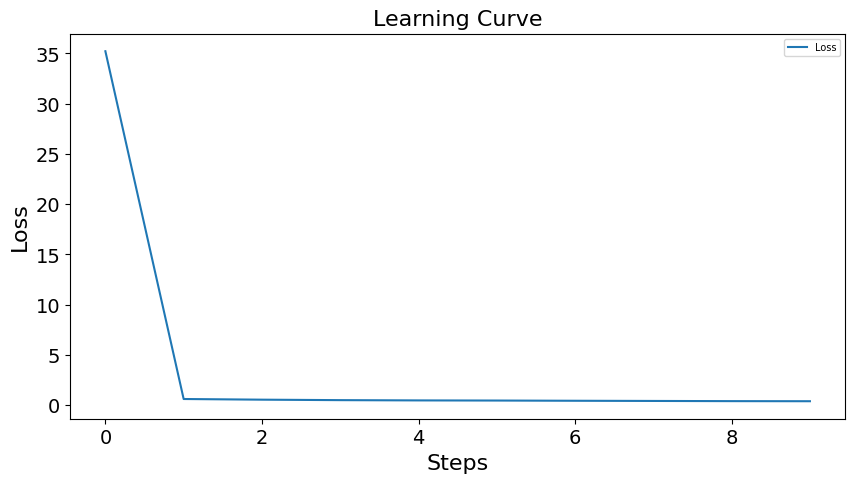

In [6]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import logging

# Instantiate the network
hidden_size = 50
net = RNNNet2(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

#Initialize WD regularizer
WD_regularizer = Reg_WD(reg_WD=0.3, neuron_num= hidden_size, network_structure=(5,5,2))
feedback_matrix = torch.randn(hidden_size, output_size) / np.sqrt(output_size)
# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#For WD regularizer
rnn_weight_matrices = []

online_learning = True  # Set to False for offline learning
learning_rate = 0.01



loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(2000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)
    WD_cost = WD_regularizer((net.rnn.h2h.weight))
    total_cost = loss + WD_cost
    running_loss += total_cost.item()
    # Backward pass


    total_cost.backward()
    # Update weights
    optimizer.step()
    rnn_weight_matrices.append(net.rnn.h2h.weight.detach().clone())
    # Update running loss

    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

# Plotting the learning curve
plt.figure(figsize=(10,5))
plt.title("Learning Curve", fontsize = 16)
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps",fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.show()


Testing

In [7]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1


for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average performance 0.862


Neural Analysis

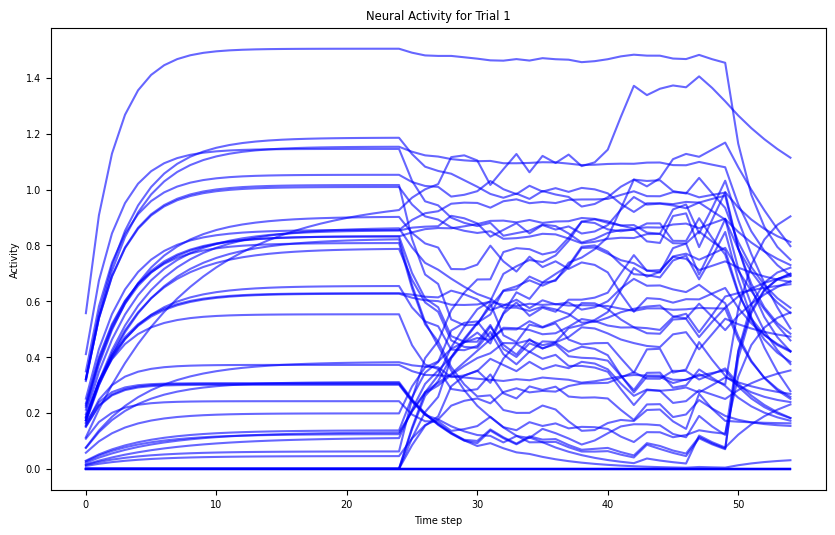

"\ne_size = net.rnn.e_size\n\n\nplt.figure()\n_ = plt.plot(activity_dict[trial][:, :e_size], color='blue', label='Excitatory')\n_ = plt.plot(activity_dict[trial][:, e_size:], color='red', label='Inhibitory')\nplt.xlabel('Time step')\nplt.ylabel('Activity')\n"

In [15]:
 #@title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt
trial =1


"""
For LeakyRNN
"""

plt.figure(figsize=(10, 6))
plt.plot(activity_dict[trial], color='blue', alpha=0.6)
plt.xlabel('Time step')
plt.ylabel('Activity')
plt.title(f'Neural Activity for Trial {trial}')
plt.show()


"""
For the EIRNN
"""


"""
e_size = net.rnn.e_size


plt.figure()
_ = plt.plot(activity_dict[trial][:, :e_size], color='blue', label='Excitatory')
_ = plt.plot(activity_dict[trial][:, e_size:], color='red', label='Inhibitory')
plt.xlabel('Time step')
plt.ylabel('Activity')
"""

PCA

Shape of the neural activity (Time points, Neurons): (27500, 50)
Shape of the projected activity (Time points, PCs): (27500, 2)


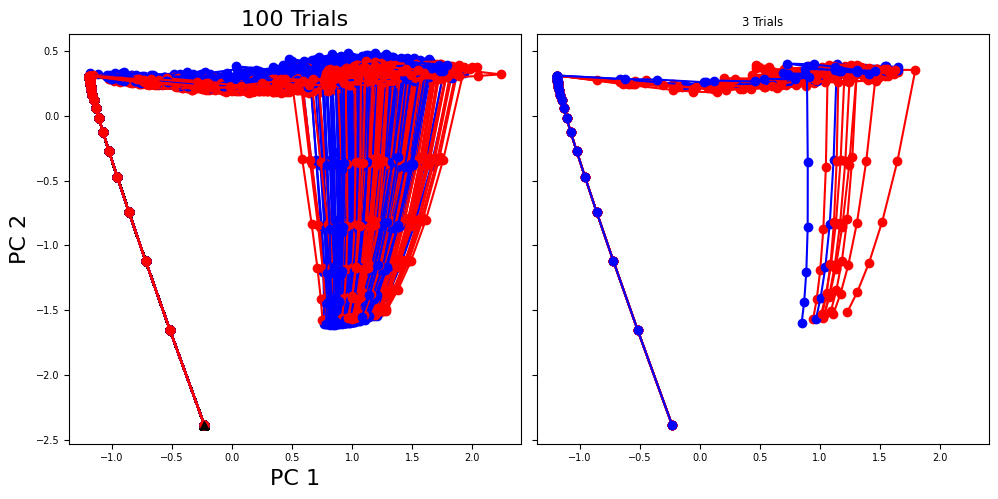

In [9]:
from sklearn.decomposition import PCA

import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyze

# Adjust the time limit for plotting
plot_until_time = 70

# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(n_components=2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D)
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(500):
    # Transform and plot each trial
    activity_pc_trial = pca.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'

    ax1.plot(activity_pc_trial[:plot_until_time, 0], activity_pc_trial[:plot_until_time, 1], 'o-', color=color)
    if i < 10:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc_trial[:plot_until_time, 0], activity_pc_trial[:plot_until_time, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc_trial[0, 0], activity_pc_trial[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('100 Trials', fontsize = 16)
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1', fontsize = 16)
ax1.set_ylabel('PC 2', fontsize = 16)

plt.tight_layout()
plt.show()

Lesioning

In [12]:
# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.5

num_neurons_to_lesion = int(lesion_fraction * net.rnn.hidden_size)  # Lesion top 20% most selective neurons
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

# Lesion function: Set weights to zero for selected neurons
def lesion_network(net, selective_neurons):
    with torch.no_grad():  # Ensure no gradients are recorded for this modification
        # Set weights of the selected neurons to zero
        net.rnn.h2h.weight[selective_neurons, :] = 0
        net.rnn.h2h.weight[:, selective_neurons] = 0

# Save initial weights for resetting after experiment
initial_weights = net.rnn.h2h.weight.clone()

# Lesion the network
lesion_network(net, selective_neurons)

# Re-run the training/evaluation to observe the impact of lesioning on performance
loss_values_lesioned = []  # List to store loss values post-lesioning
running_loss_lesioned = 0.0

print('Evaluating network after lesioning top 20% of neurons...')
for i in range(300):  # Fewer steps to evaluate effect
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # # Backward pass
    # loss.backward()

    # # Update weights
    # optimizer.step()

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)  # Append average loss here
        running_loss_lesioned = 0.0

# Reset weights after lesioning to original state
net.rnn.h2h.weight = nn.Parameter(initial_weights)

Evaluating network after lesioning top 20% of neurons...
Step 200, Lesioned Network Loss 0.1515


 without e size

In [11]:
mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d' (selectivity) for all neurons
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

# Sort index for selectivity across all neurons (no E/I separation)
ind_sort = np.argsort(selectivity)

with E-size

In [38]:
e_size = net.rnn.e_size

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(stim_activity[ground_truth], axis=0)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2+std_activity[1]**2+1e-7)/2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:])+e_size))

Connectivity

Text(0.5, 1.0, 'Network connectivity')

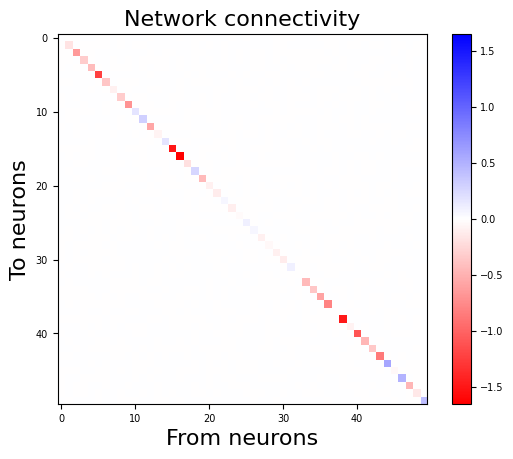

In [16]:
#W = net.rnn.h2h.effective_weight().detach().numpy()
W = net.rnn.h2h.weight.detach().cpu().numpy()
# Sort by selectivity
W = W[:, ind_sort][ind_sort, :]
wlim = np.max(np.abs(W))
plt.figure()
plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
plt.colorbar()
plt.xlabel('From neurons',fontsize=16)
plt.ylabel('To neurons',fontsize=16)
plt.title('Network connectivity',fontsize=16)

Analyse effect

Fixed points

In [ ]:
# Path to the uploaded file
!unzip /content/fixed-point-finder-master.zip -d /content/

# Navigate to the extracted directory
%cd /content/fixed-point-finder-master

# Install required dependencies from the requirements file
!pip install -r requirements-torch

# Install dependencies
!pip install numpy==1.24.3 scikit-learn==1.2.2 matplotlib==3.7.1 torch==1.12.1

Archive:  /content/fixed-point-finder-master.zip
replace /content/__MACOSX/._fixed-point-finder-master? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/__MACOSX/._fixed-point-finder-master  
  inflating: /content/__MACOSX/fixed-point-finder-master/._paper  
  inflating: /content/fixed-point-finder-master/FixedPointFinderTorch.py  
  inflating: /content/__MACOSX/fixed-point-finder-master/._FixedPointFinderTorch.py  
  inflating: /content/fixed-point-finder-master/FixedPoints.py  
  inflating: /content/__MACOSX/fixed-point-finder-master/._FixedPoints.py  
  inflating: /content/fixed-point-finder-master/LICENSE  
  inflating: /content/__MACOSX/fixed-point-finder-master/._LICENSE  
  inflating: /content/__MACOSX/fixed-point-finder-master/._test  
  inflating: /content/fixed-point-finder-master/README.md  
  inflating: /content/__MACOSX/fixed-point-finder-master/._README.md  
  inflating: /content/fixed-point-finder-master/FixedPointFinderBase.py  
  inflating: /content/__MACO

In [ ]:
# Add the path to the directory containing FixedPointFinderTorch.py
import sys
sys.path.append('/content/__MACOSX/fixed-point-finder-master')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch
# Now you can create an instance of FixedPointFinderTorch with your RNN

In [ ]:
class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Use only the first part of the hidden state
        hidden = hidden[0].squeeze(0)  # Extract the first tensor and remove the extra dimension

        # Forward pass through the RNN with the modified hidden state
        output, new_hidden = self.rnn(input, (hidden, hidden))  # Keep the cell state the same for simplicity

        # Unsqueeze the first tensor in the hidden state to match FixedPointFinder's expectation
        new_hidden = new_hidden[0].unsqueeze(0)  # Get the hidden state (not the cell state) and add back the dimension

        # Return None for output as per FixedPointFinder's requirement
        return None, new_hidden
        return None, hidden

In [178]:
# Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(net.rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder = FixedPointFinder(rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, net.rnn.hidden_size)  # 10 random initial hidden states
inputs = torch.zeros(10, net.rnn.input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

# Run fixed-point finding using the wrapped model
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute





Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 5.97e-01 +/- 1.68e-01
		dq = 1.54e-01 +/- 1.06e-01
		learning rate = 1.97e-07
		avg iter time = 9.33e-04 sec
	Identified 10 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 10).
	Computing recurrent Jacobian at 10 unique fixed points.
	Computing input Jacobian at 10 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



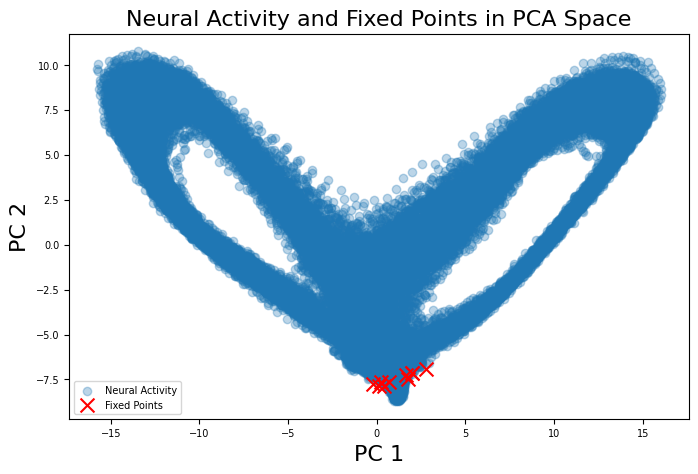

In [ ]:
# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1", fontsize = 16)
plt.ylabel("PC 2", fontsize = 16)
plt.title("Neural Activity and Fixed Points in PCA Space", fontsize = 16)
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 6.39e-01 +/- 9.28e-02
		dq = 1.52e-01 +/- 1.04e-01
		learning rate = 1.97e-07
		avg iter time = 1.11e-03 sec
	Identified 10 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 10).
	Computing recurrent Jacobian at 10 unique fixed points.
	Computing input Jacobian at 10 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 5.45e-01 +/- 7.70e-02
		dq = 1.30e-01 +/- 9.18e-02
		

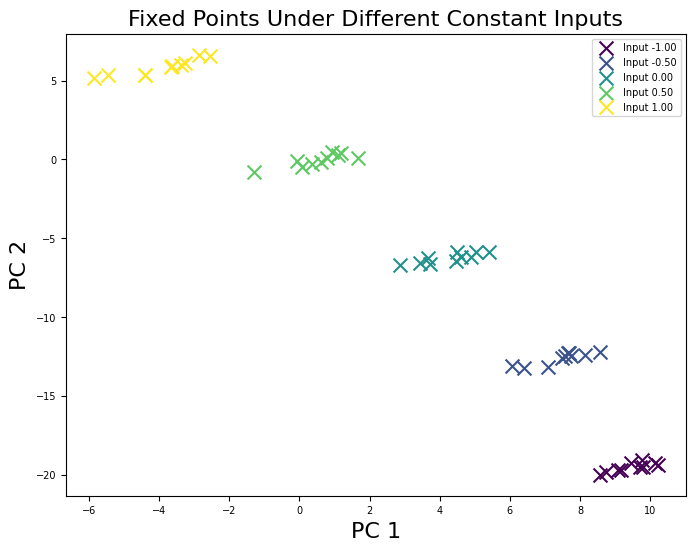

In [ ]:
# Define different constant inputs
input_values = np.linspace(-1, 1, 5)  # 5 different input values
fixed_points_by_input = []

for input_val in input_values:
    # Prepare constant input
    inputs_np = np.full((10, net.rnn.input_size), input_val)  # Batch of 10 initial conditions

    # Use the same initial conditions as before
    init_hidden_np = initial_conditions.cpu().numpy()

    # Find fixed points with the current input
    fps_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))

# Plot fixed points for different inputs
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input):
    # Project fixed points into PCA space
    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1', fontsize = 16)
plt.ylabel('PC 2', fontsize = 16)
plt.title('Fixed Points Under Different Constant Inputs', fontsize = 16)
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


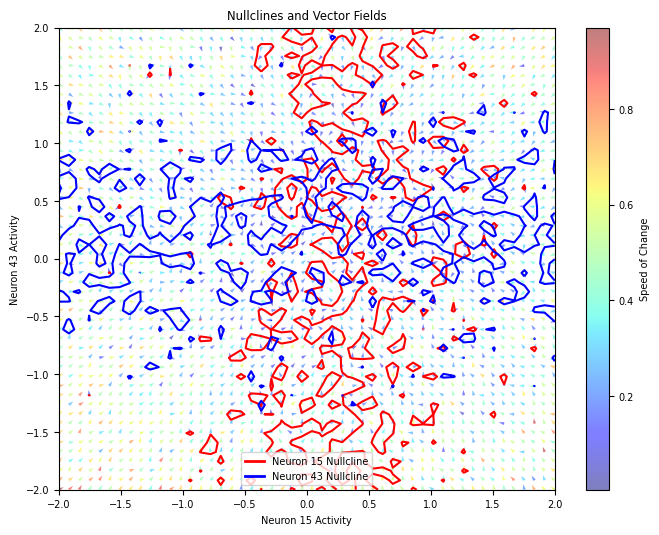

In [ ]:
# Select two neurons with highest selectivity
from matplotlib.lines import Line2D

selectivity_indices = np.argsort(np.abs(selectivity))[-2:]
neuron1, neuron2 = selectivity_indices

# Define ranges for the two neurons
n_points = 50
state_range = np.linspace(-2, 2, n_points)
neuron1_states, neuron2_states = np.meshgrid(state_range, state_range)

# Flatten the grids
grid_states = np.c_[neuron1_states.ravel(), neuron2_states.ravel()]

# Prepare inputs (constant zero input)
inputs = torch.zeros(grid_states.shape[0], net.rnn.input_size).type(torch.float32)

# Prepare initial states for all neurons, keeping other neurons at zero
initial_states = np.zeros((grid_states.shape[0], net.rnn.hidden_size))
initial_states[:, neuron1] = grid_states[:, 0]
initial_states[:, neuron2] = grid_states[:, 1]

initial_hidden_state = torch.from_numpy(initial_states).type(torch.float32)
initial_cell_state = torch.zeros_like(initial_hidden_state)
initial_states_tensor = (initial_hidden_state, initial_cell_state)

# Run one step of the RNN, using the tuple for two-tensor hidden states
_, (next_hidden, next_cell) = net.rnn(inputs.unsqueeze(0), initial_states_tensor)
next_states = next_hidden.detach().cpu().numpy()

# Compute derivatives for the two neurons
d_neuron1 = next_states[:, neuron1] - initial_states[:, neuron1]
d_neuron2 = next_states[:, neuron2] - initial_states[:, neuron2]

# Reshape to grid
d_neuron1_grid = d_neuron1.reshape(neuron1_states.shape)
d_neuron2_grid = d_neuron2.reshape(neuron2_states.shape)

# Compute vector field
U = d_neuron1_grid  # Change in neuron1
V = d_neuron2_grid  # Change in neuron2

# Normalize the vector field for better visualization
speed = np.sqrt(U**2 + V**2)
U_norm = U / speed
V_norm = V / speed

# Plot nullclines and vector field
plt.figure(figsize=(8, 6))
plt.contour(neuron1_states, neuron2_states, d_neuron1_grid, levels=[0], colors='red')
plt.contour(neuron1_states, neuron2_states, d_neuron2_grid, levels=[0], colors='blue')
plt.quiver(neuron1_states, neuron2_states, U_norm, V_norm, speed, cmap='jet', alpha=0.5)

# legend entries
legend_elements = [Line2D([0], [0], color='red', lw=2, label=f'Neuron {neuron1} Nullcline'),
                   Line2D([0], [0], color='blue', lw=2, label=f'Neuron {neuron2} Nullcline')]
plt.legend(handles=legend_elements + plt.gca().get_legend_handles_labels()[0])

plt.xlabel(f'Neuron {neuron1} Activity')
plt.ylabel(f'Neuron {neuron2} Activity')
plt.title('Nullclines and Vector Fields')
plt.colorbar(label='Speed of Change')
plt.show()
